In [2]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [3]:
import imp

In [24]:
imp.reload(xy)

<module 'xy' from 'E:\\PyProject\\factors\\TPS\\xy.py'>

In [5]:
import xy

# $因子描述：TPS$

***计算每个标的换手率多头组合的收益率，即标的放量收益率和缩量收益率之差***  
从个股上看，换手多空动量是一个空头指标，这意味着过去20日内，**出现放量下跌且缩量上涨的标的更有可能在次日上涨**，而在指数强弱上体现了相反的规律，以此为切入点改进“个股 —— 指数”的映射方式。

1. 数据：股票日线行情、换手率  
2. 滚动20日，使用换手率最高的5日，和换手最低的五日收益率作为样本，分别计算其收益率均值得到 arr5 和 arr1；
3. arr5-arr1得到换手多空动量。
4. **在映射到指数的过程中，剔除中间噪声标的**

## 计算

In [6]:
rwr = xy.rolling_window(xy.rets,20)
rwt_rank = np.argsort(xy.rolling_window(xy.turns,20),axis=2)

In [89]:
arr5 = []
arr3 = []
arr1 = []
for i0, j0 in tqdm(zip(range(rwt_rank.shape[0]),range(rwr.shape[0]))):
    st_arr5 = []
    st_arr3 = []
    st_arr1 = []
    for i1, j1 in zip(range(rwt_rank.shape[1]),range(rwr.shape[1])):
        st_sorted_ret = rwr[j0][j1][rwt_rank[i0][i1]]
        
        # 换手率最高的5个收益率
        st_arr5.append(np.nanmean(st_sorted_ret[-5:]))
        
        # 换手率居中的5个收益率
        st_arr3.append(np.nanmean(st_sorted_ret[5:-5]))
        
        # 换手率最小的5个收益率
        st_arr1.append(np.nanmean(st_sorted_ret[:5]))
    
    arr5.append(st_arr5)
    arr3.append(st_arr3)
    arr1.append(st_arr1)

4929it [07:24, 11.10it/s]


In [90]:
TR5_df = pd.DataFrame(np.array(arr5)[:,:-1],index = xy.rets.index,columns = xy.rets.columns[19:])
TR3_df = pd.DataFrame(np.array(arr3)[:,:-1],index = xy.rets.index,columns = xy.rets.columns[19:])
TR1_df = pd.DataFrame(np.array(arr1)[:,:-1],index = xy.rets.index,columns = xy.rets.columns[19:])
New_TSR1 = ((TR5_df-TR5_df.mean())/TR5_df.std() - (TR1_df-TR1_df.mean())/TR1_df.std()).shift(1,axis=1)

In [76]:
# 放量的时候要跌，缩量的时候要涨
xy.cal_rate_group(
    New_TSR1,
    xy.rets,
    group_num=10,
    masks=1
).cumsum()

-0.14453192434712334
1 362.8310700706138
2 363.33079847908743
3 363.2275936990766
4 363.3286257468767
5 363.42694187941333
6 363.1347093970668
7 363.22868006518195
8 363.3275393807713
9 363.23085279739274
10 363.74579033134165


,group1,group2,group3,group4,group5,group6,group7,group8,group9,group10
2016-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-02,0.041497,0.021716,0.032571,0.035580,0.035522,0.037137,0.036318,0.039324,0.043489,0.047131
2016-02-03,0.049117,0.029046,0.035661,0.044348,0.041017,0.041978,0.041244,0.043635,0.049746,0.052347
2016-02-04,0.077344,0.055787,0.046129,0.067006,0.065310,0.065211,0.065380,0.065593,0.076433,0.078449
2016-02-05,0.067936,0.047143,0.037366,0.057639,0.056669,0.061548,0.060442,0.054322,0.064379,0.061974
...,...,...,...,...,...,...,...,...,...,...
2023-08-18,1.019154,0.991508,0.911123,0.836515,0.891070,0.640845,0.543715,0.306001,0.154858,-0.598448
2023-08-21,1.013773,0.984950,0.904134,0.830221,0.885183,0.633270,0.537967,0.300033,0.147046,-0.604486
2023-08-22,1.013743,0.986113,0.904150,0.830296,0.884235,0.635524,0.538817,0.304251,0.153651,-0.591444
2023-08-23,0.993578,0.969449,0.888853,0.814858,0.868598,0.620181,0.522661,0.287463,0.136224,-0.611368


-0.1516145069740599
1 362.90010857763303
2 363.40010857763303
3 363.2969598262758
4 363.39793702497286
5 363.4961997828447
6 363.2035830618893
7 363.29804560260584
8 363.3968512486428
9 363.300217155266
10 363.81487513572205


<Axes: >

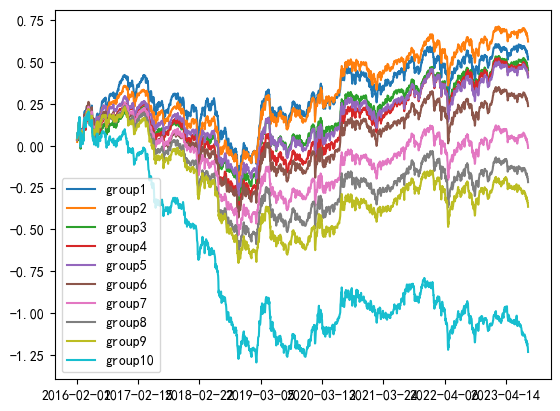

In [10]:
# 放量的时候要跌，缩量的时候要涨
xy.cal_rate_group(
    New_TSR1,
    xy.rets,
    group_num=10,
    masks=1
).cumsum().plot()

In [96]:
org_New_TSR1_idx = xy.read_Factor(xy.trd_dates,'New_TSR1',df=((TR3_df-TR3_df.mean())/TR3_df.std()))#New_TSR1[(New_TSR1.rank()>4000)|(New_TSR1.rank()<1000)]

0.0072979367508431816
1 0.9897794513179129
2 0.9897794513179129
3 0.9897794513179129
4 0.9897794513179129


<Axes: >

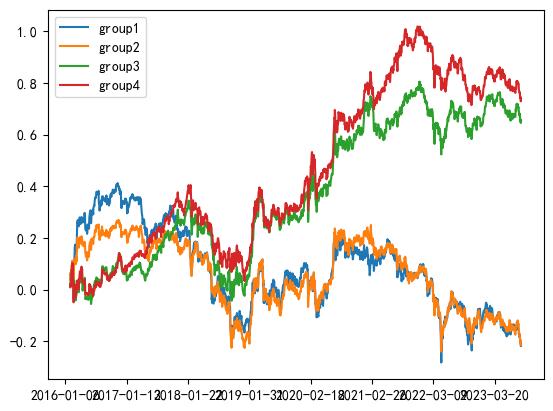

In [97]:
# 分组收益率
xy.cal_rate_group(
    org_New_TSR1_idx,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

In [ ]:
# 反转因子，市值中性化，统计有效期间

-0.018188606287010085
1 9.337931034482759
2 10.035467980295566
3 9.804433497536946
4 10.075862068965517
5 10.001970443349753
6 9.532512315270935
7 9.978817733990148
8 9.901477832512315
9 9.938423645320198
10 10.244827586206897


<Axes: >

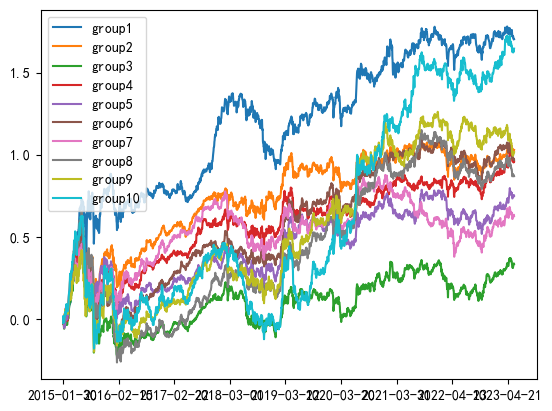

In [43]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1.loc[New_TSR1.index.isin(xy.weights50.index)],
    xy.rets,
    group_num=10,
    masks=1
).cumsum().plot()

-0.13045513874583925
1 187.23845736013035
2 187.6610537751222
3 187.58337859858773
4 187.69799022270504
5 187.73601303639327
6 187.48126018468224
7 187.60836501901142
8 187.67300380228136
9 187.57142857142858
10 188.02281368821292


<Axes: >

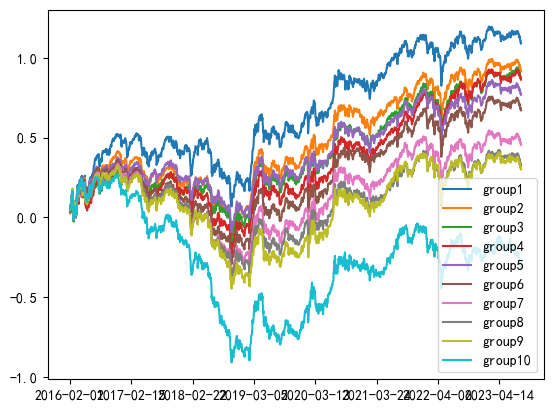

In [51]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1.loc[New_TSR1.index.isin( xy.weights1000.index )],
    xy.rets,
    group_num=10,
    masks=1
).cumsum().plot()

-0.1276847798679032
1 190.87724063009233
2 191.4106463878327
3 191.30472569255838
4 191.3720803910918
5 191.4986420423683
6 191.18685497012493
7 191.29712112982074
8 191.37968495382944
9 191.33568712656165
10 191.78707224334602


<Axes: >

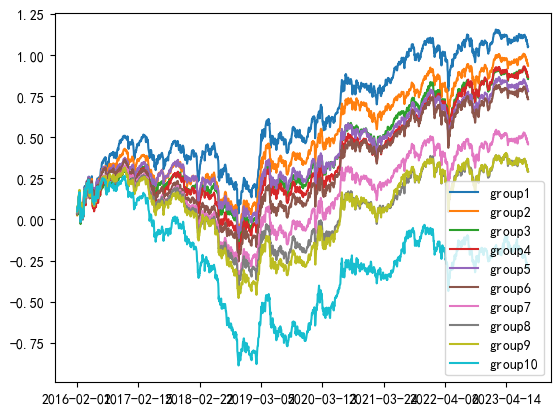

In [94]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1.loc[New_TSR1.index.isin( xy.weights1000.index )],
    xy.rets,
    group_num=10,
    masks=1
).cumsum().plot()

In [74]:
New_TSR1_idx = xy.read_Factor(xy.trd_dates,'New_TSR1',df=New_TSR1)#New_TSR1[(New_TSR1.rank()>4000)|(New_TSR1.rank()<1000)]

In [71]:
New_TSR1_idx

,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-18,2016-01-19,...,2023-08-14,2023-08-15,2023-08-16,2023-08-17,2023-08-18,2023-08-21,2023-08-22,2023-08-23,2023-08-24,2023-08-25
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.937117,-1.180692,-1.476775,-1.034832,-0.975207,-0.260639,0.252257,-0.529100,-0.604015,-0.998251
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.787469,1.264668,0.673816,1.274162,1.382289,1.366259,1.082966,1.341640,-0.940828,-0.650839
500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.776833,-0.002905,0.547659,0.252488,-0.037124,-0.076257,-0.007254,0.136843,1.300029,1.156325
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.947753,-0.081072,0.255300,-0.491818,-0.369958,-1.029363,-1.327968,-0.949383,0.244813,0.492764


0.05763905573228203
1 0.9892415277030662
2 0.9892415277030662
3 0.9892415277030662
4 0.9892415277030662


<Axes: >

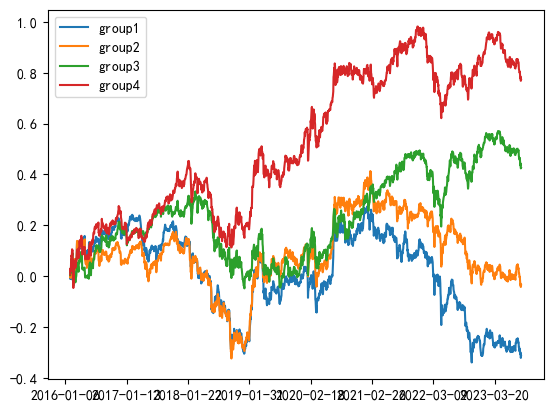

In [95]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1_idx,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

0.05763905573228203
1 0.9892415277030662
2 0.9892415277030662
3 0.9892415277030662
4 0.9892415277030662


<Axes: >

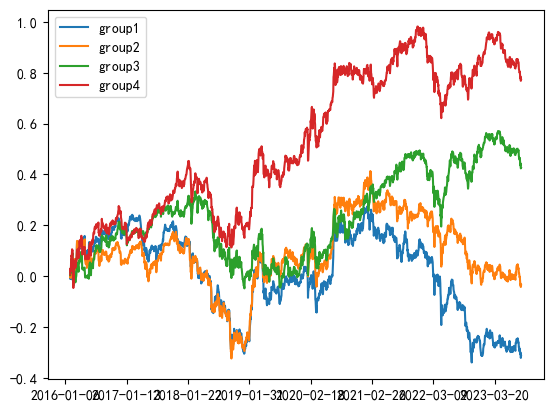

In [82]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1_idx,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

0.03806414402201379
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

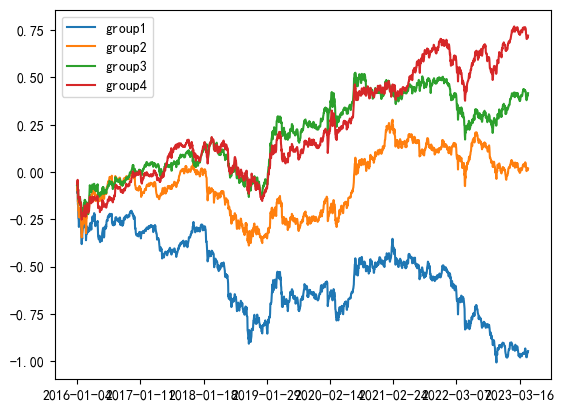

In [32]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1_idx,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

In [66]:
xy.Index_rets.loc[['50','1000'],'2016-01-07':]

,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-18,2016-01-19,2016-01-20,...,2023-08-15,2023-08-16,2023-08-17,2023-08-18,2023-08-21,2023-08-22,2023-08-23,2023-08-24,2023-08-25,2023-08-28
50,-0.059137,0.017896,-0.044773,0.005251,-0.012134,0.012619,-0.028680,-0.000799,0.028657,-0.018722,...,-0.001115,-0.006139,0.002244,-0.011397,-0.012957,0.007545,-0.013063,0.007949,0.001847,0.013218
1000,-0.087859,0.002231,-0.075610,-0.002092,-0.042970,0.041043,-0.035496,0.024493,0.040629,-0.007986,...,-0.009126,-0.012030,0.009892,-0.020887,-0.009798,0.006938,-0.020580,0.002393,-0.018193,0.007337


In [67]:
New_TSR1_idx

,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-18,2016-01-19,...,2023-08-14,2023-08-15,2023-08-16,2023-08-17,2023-08-18,2023-08-21,2023-08-22,2023-08-23,2023-08-24,2023-08-25
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.002885,0.560620,0.686556,-0.391082,-0.691308,-0.082195,0.166099,-0.775356,-1.174057,-1.121637
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.712573,1.121436,1.025317,1.431788,1.483326,1.395728,1.154433,1.184489,-0.459467,-0.519903
500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.770937,-0.922968,-0.778118,-0.162929,-0.332008,-0.354687,-0.040673,0.470754,1.012054,1.070073
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.944520,-0.759089,-0.933755,-0.877777,-0.460010,-0.958846,-1.279860,-0.879887,0.621470,0.571467


746.0
yoy: 0.16428149086737895 
 mdd: -0.40562485469703125 
 sharpe: 0.8412738067606186 
 rankIC: 0.0032608695652173877 
 rankIR: 0.0032600006712100596 
 win%: 0.4965034965034965 
 gain_loss%: -1.1458073751172746


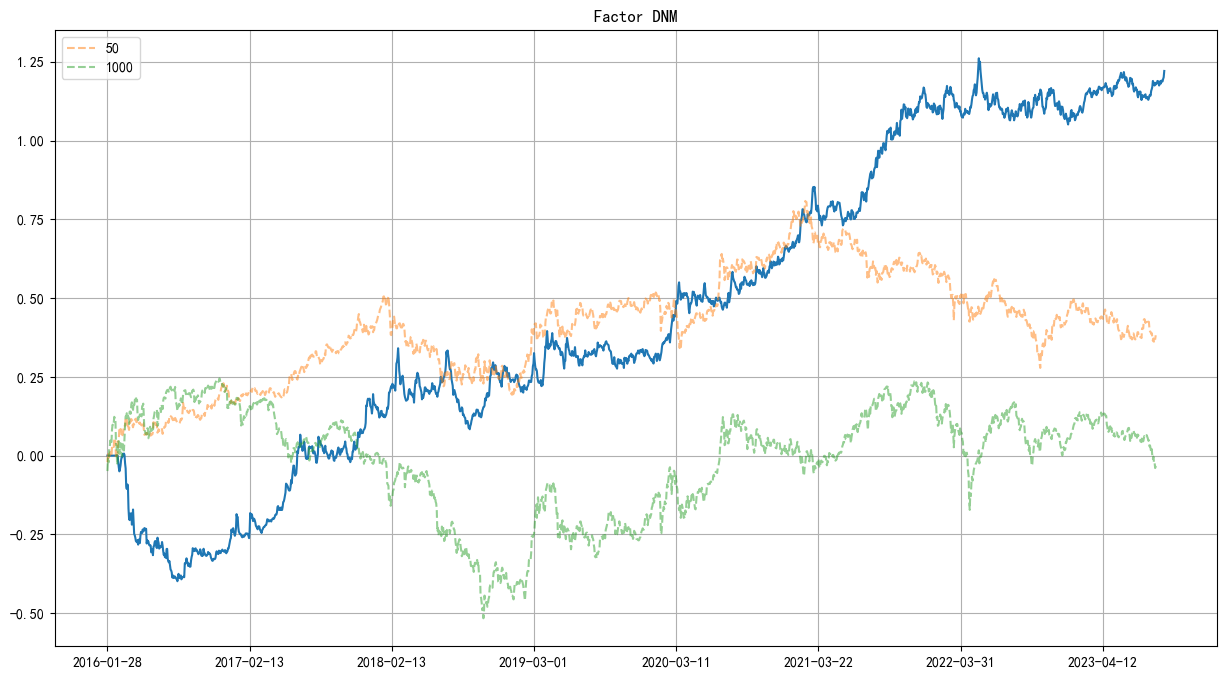

In [98]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    org_New_TSR1_idx.loc[['50','1000'],:],# ['50','1000']
    xy.Index_rets.loc[['50','1000'],'2016-01-28':],
    _side=1,
    fee=0.00,
    name='DNM'
)

838.0
yoy: 0.2552198437393319 
 mdd: -0.3682993551340993 
 sharpe: 1.2943384946184429 
 rankIC: 0.039049235993208815 
 rankIR: 0.03906798247372473 
 win%: 0.5142857142857142 
 gain_loss%: -1.1520449517099678


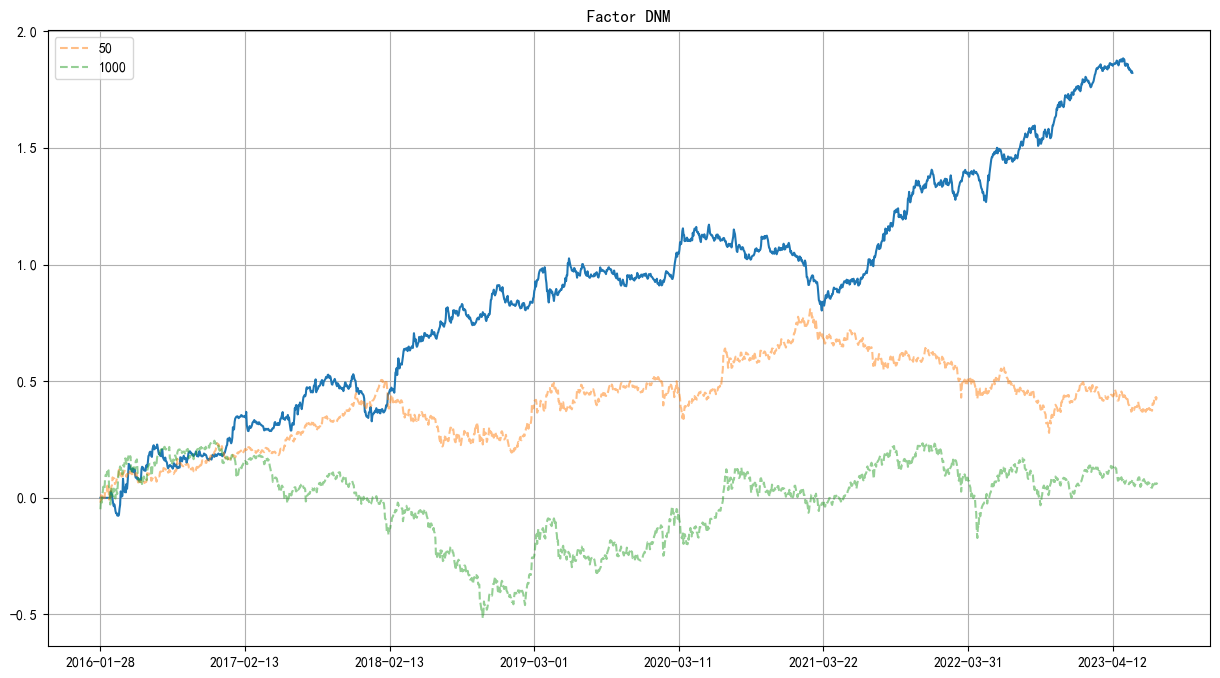

In [33]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    New_TSR1_idx.loc[['50','1000'],:],# ['50','1000']
    xy.Index_rets.loc[['50','1000'],'2016-01-28':],
    _side=1,
    fee=0.00,
    name='DNM'
)

In [111]:
New_TSR1_idx

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-05-24,2023-05-25,2023-05-26,2023-05-29,2023-05-30,2023-05-31,2023-06-01,2023-06-02,2023-06-05,2023-06-06
50,0.962962,0.905180,1.155897,0.606296,0.764528,1.313461,1.311309,1.361990,1.242439,1.209194,...,1.061463,1.293808,1.241196,1.215117,0.924308,-0.027575,-0.338067,-0.766041,-0.967313,-0.910719
300,0.302050,0.373900,0.337662,0.595247,0.281042,0.131593,0.086411,0.031007,0.295041,0.243965,...,-1.350465,-1.133674,-1.149904,-1.048389,-1.338408,-0.873608,-0.903887,-0.892070,-0.610647,-0.645957
500,0.136045,0.142389,-0.280665,0.281338,0.423233,-0.395867,-0.314030,-0.401708,-0.462659,-0.266963,...,0.082132,0.038302,-0.303509,-0.536393,-0.159406,-0.505961,-0.184464,0.480685,0.316520,0.257900
1000,-1.401057,-1.421469,-1.212894,-1.482881,-1.468804,-1.049187,-1.083691,-0.991289,-1.074822,-1.186196,...,0.206869,-0.198436,0.212217,0.369666,0.573506,1.407143,1.426419,1.177426,1.261440,1.298776


806.0
yoy: 0.2476559274633037 
 mdd: -0.3904276092963336 
 sharpe: 1.2586119516269596 
 rankIC: 0.02518186905428091 
 rankIR: 0.025182808027500548 
 win%: 0.5074792243767313 
 gain_loss%: -1.1770526951239695


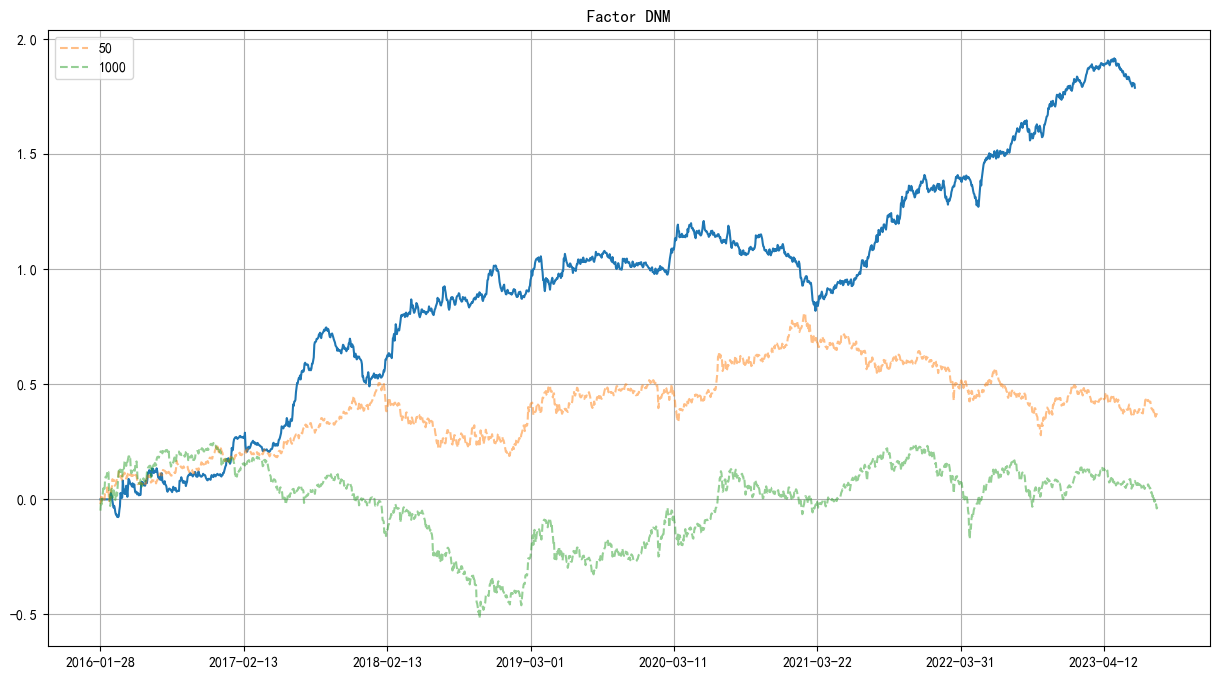

In [114]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    New_TSR1_idx.loc[['50','1000'],:],# ['50','1000']
    xy.Index_rets.loc[['50','1000'],'2016-01-28':],
    _side=1,
    fee=0.00,
    name='DNM'
)

In [217]:
New_TSR1_idx

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-04-21,2023-04-24,2023-04-25,2023-04-26,2023-04-27,2023-04-28,2023-05-04,2023-05-05,2023-05-08,2023-05-09
50,1.162610,1.178631,1.071053,1.074626,1.172423,1.285050,1.310740,1.336981,1.133745,1.127067,...,-1.403125,-1.293744,-1.175258,-1.489783,-1.418608,-1.378618,-1.321552,-0.932959,0.169829,-0.659408
300,0.279121,0.345265,0.455569,0.425751,0.317748,0.176470,0.047593,0.070889,0.265621,0.245809,...,0.334108,0.242778,0.428628,0.405793,0.106269,-0.044465,-0.009263,-0.164370,1.346187,-0.764973
500,-0.205534,-0.355443,-0.273406,-0.231368,-0.290028,-0.377569,-0.256579,-0.374990,-0.123074,-0.083570,...,0.117248,-0.072439,-0.387053,0.422912,0.416233,0.505567,0.236524,1.414836,-0.827962,1.407017
1000,-1.236198,-1.168453,-1.253216,-1.269009,-1.200143,-1.083950,-1.101754,-1.032880,-1.276292,-1.289307,...,0.951769,1.123405,1.133683,0.661078,0.896107,0.917517,1.094291,-0.317506,-0.688054,0.017364


In [517]:
import jqdatasdk
jqdatasdk.auth(username='13602599243',password='JoinQuant897617209')

auth success 


In [507]:
new_idx = []
for i in xy.weights1000.index:
    if i[-2:] == 'SZ':
        new_idx.append(i[:-3]+'.XSHE')
    else:
        new_idx.append(i[:-3]+'.XSHG')

['000005.XSHE',
 '000006.XSHE',
 '000008.XSHE',
 '000010.XSHE',
 '000011.XSHE',
 '000014.XSHE',
 '000016.XSHE',
 '000018.XSHE',
 '000019.XSHE',
 '000025.XSHE',
 '000028.XSHE',
 '000029.XSHE',
 '000030.XSHE',
 '000032.XSHE',
 '000034.XSHE',
 '000035.XSHE',
 '000036.XSHE',
 '000038.XSHE',
 '000040.XSHE',
 '000042.XSHE',
 '000048.XSHE',
 '000049.XSHE',
 '000055.XSHE',
 '000056.XSHE',
 '000058.XSHE',
 '000059.XSHE',
 '000061.XSHE',
 '000065.XSHE',
 '000070.XSHE',
 '000088.XSHE',
 '000089.XSHE',
 '000090.XSHE',
 '000096.XSHE',
 '000150.XSHE',
 '000151.XSHE',
 '000153.XSHE',
 '000155.XSHE',
 '000158.XSHE',
 '000159.XSHE',
 '000301.XSHE',
 '000403.XSHE',
 '000404.XSHE',
 '000407.XSHE',
 '000409.XSHE',
 '000410.XSHE',
 '000416.XSHE',
 '000419.XSHE',
 '000422.XSHE',
 '000423.XSHE',
 '000426.XSHE',
 '000428.XSHE',
 '000429.XSHE',
 '000488.XSHE',
 '000498.XSHE',
 '000503.XSHE',
 '000506.XSHE',
 '000507.XSHE',
 '000514.XSHE',
 '000516.XSHE',
 '000517.XSHE',
 '000518.XSHE',
 '000520.XSHE',
 '000521

In [189]:
Index_turnover = pd.concat([
    (xy.turns*xy.weights50).dropna(how='all',axis=1).sum().rename('50'),
    (xy.turns*xy.weights300).dropna(how='all',axis=1).sum().rename('300'),
    (xy.turns*xy.weights500).dropna(how='all',axis=1).sum().rename('500'),
    (xy.turns*xy.weights1000).dropna(how='all',axis=1).sum().rename('1000')
],axis=1).shift(1).T

In [179]:
Index_OrgMom = pd.concat([
    (Orig_Mom*xy.weights50).dropna(how='all',axis=1).sum().rename('50'),
    (Orig_Mom*xy.weights300).dropna(how='all',axis=1).sum().rename('300'),
    (Orig_Mom*xy.weights500).dropna(how='all',axis=1).sum().rename('500'),
    (Orig_Mom*xy.weights1000).dropna(how='all',axis=1).sum().rename('1000')
],axis=1).T

In [388]:
def get_ovn_money_mom(ser):
    # 隔夜成交量,昨日最后5分钟量
    fore_ovn_money = pd.Series(np.nansum(xy.rolling_window(ser.money,5)[235::240],axis=1),ser[::240].index.map(lambda x: str(x)[:10]))

    # 隔夜动量
    open1min50 = ser[::240].open
    close1min50 = ser[239::240].close
    
    open1min50.index = open1min50.index.map(lambda x:str(x)[:10])
    close1min50.index = close1min50.index.map(lambda x:str(x)[:10])
    
    ovn_mom = (open1min50/close1min50.shift(1) - 1)
    
    return fore_ovn_money, ovn_mom

In [85]:
def tov_rank(x):
    xrk = x.rank()
    return list(xrk)

In [421]:
def inraday_mom(
    idx_name,
    Index_turnover,
    ret,
    winsize
):
    TRs1 = []
    TRs2 = []
    TRs3 = []
    TRs4 = []
    TRs5 = []
    dts = []
    for _, win in enumerate(Index_turnover.T[idx_name].rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = ret.T[idx_name][_-winsize+1:_+1]
        TRs1.append(rt[rk < (winsize/5)+1].mean())
        TRs2.append(rt[(rk >= (winsize/5)+1)&(rk < 2*(winsize/5)+1)].mean())
        TRs3.append(rt[(rk >= 2*(winsize/5)+1)&(rk < 3*(winsize/5)+1)].mean())
        TRs4.append(rt[(rk >= 3*(winsize/5)+1)&(rk < 4*(winsize/5)+1)].mean())
        TRs5.append(rt[rk >= 4*(winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs1,dts),pd.Series(TRs2,dts),pd.Series(TRs3,dts),pd.Series(TRs4,dts),pd.Series(TRs5,dts)

In [421]:
def inraday_mom_all1(
    tov,
    winsize=20
):
    TRs1 = []
    dts = []
    for _, win in enumerate(tov.rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = xy.ret[_-winsize+1:_+1]
        TRs1.append(rt[rk < (winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs1,dts)

def inraday_mom_all5(
    tov,
    winsize
):
    TRs5 = []
    dts = []
    for _, win in enumerate(tov.rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = xy.ret[_-winsize+1:_+1]
        TRs5.append(rt[rk > 4*(winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs5,dts)

In [ ]:
trs50_1,trs50_2,trs50_3,trs50_4,trs50_5 = inraday_mom('50',Index_turnover,xy.Index_rets,20)
trs300_1,trs300_2,trs300_3,trs300_4,trs300_5 = inraday_mom('300',Index_turnover,xy.Index_rets,20)
trs500_1,trs500_2,trs500_3,trs500_4,trs500_5 = inraday_mom('500',Index_turnover,xy.Index_rets,20)
trs1000_1,trs1000_2,trs1000_3,trs1000_4,trs1000_5 = inraday_mom('1000',Index_turnover,xy.Index_rets,20)

In [486]:
TSR5 = pd.concat([
    trs50_5.rename('50'),
    trs300_5.rename('300'),
    trs500_5.rename('500'),
    trs1000_5.rename('1000')
],axis=1).T

TSR1 = pd.concat([
    trs50_1.rename('50'),
    trs300_1.rename('300'),
    trs500_1.rename('500'),
    trs1000_1.rename('1000')
],axis=1).T

New_TSR = (TSR5 - TSR5.mean())/TSR5.std() - (TSR1 - TSR1.mean())/TSR1.std()

### 隔夜动量

#### 计算

In [399]:
fore_ovn_money50, ovn_mom50 = get_ovn_money_mom(xy.IndexMin50jq)
fore_ovn_money300, ovn_mom300 = get_ovn_money_mom(xy.IndexMin300jq)
fore_ovn_money500, ovn_mom500 = get_ovn_money_mom(xy.IndexMin500jq)
fore_ovn_money1000, ovn_mom1000 = get_ovn_money_mom(xy.IndexMin1000jq)

In [403]:
fore_ovn_money

,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-12,2009-01-13,2009-01-14,2009-01-15,2009-01-16,...,2023-05-10,2023-05-11,2023-05-12,2023-05-15,2023-05-16,2023-05-17,2023-05-18,2023-05-19,2023-05-22,2023-05-23
50,NaN,8.250600e+08,8.135700e+08,7.307400e+08,6.344200e+08,6.769100e+08,5.158634e+08,4.247900e+08,1.107980e+09,6.541400e+08,...,1.991171e+09,1.458768e+09,1.271485e+09,1.599953e+09,1.657399e+09,1.008896e+09,1.180294e+09,1.028243e+09,1.299600e+09,1.248882e+09
300,NaN,1.828710e+09,2.013940e+09,1.861210e+09,1.489030e+09,1.728810e+09,1.483170e+09,1.355240e+09,2.623140e+09,1.991300e+09,...,7.481325e+09,6.114054e+09,5.458529e+09,6.106284e+09,6.045430e+09,4.686187e+09,5.080390e+09,5.039014e+09,5.276711e+09,4.504931e+09
500,NaN,7.935900e+08,9.751000e+08,9.623200e+08,8.130200e+08,9.227900e+08,8.786500e+08,8.295500e+08,1.235610e+09,1.157390e+09,...,4.312992e+09,3.974655e+09,3.701919e+09,4.238894e+09,3.918296e+09,3.400174e+09,3.324875e+09,3.491412e+09,3.938973e+09,3.235583e+09
1000,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.445847e+09,4.811376e+09,4.712436e+09,4.915385e+09,4.815079e+09,4.122559e+09,4.339571e+09,4.773196e+09,4.808558e+09,4.283948e+09


In [404]:
fore_ovn_money = pd.concat([
    fore_ovn_money50.rename('50'),
    fore_ovn_money300.rename('300'),
    fore_ovn_money500.rename('500'),
    fore_ovn_money1000.rename('1000')
],axis=1).shift(1).T

In [405]:
fore_ovn_mom

,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-12,2009-01-13,2009-01-14,2009-01-15,2009-01-16,...,2023-05-10,2023-05-11,2023-05-12,2023-05-15,2023-05-16,2023-05-17,2023-05-18,2023-05-19,2023-05-22,2023-05-23
50,NaN,-0.005297,0.0,-0.014508,-0.003198,-0.005258,-0.011628,0.0,-0.012333,0.003112,...,-0.001478,0.003366,-0.001124,-0.000380,0.000746,-0.001122,0.002265,-0.003025,-0.000759,0.001504
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000498,0.002508,-0.000251,0.000509,-0.000250,-0.001760,0.001772,-0.002532,-0.000254,0.000757
500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000322,0.000969,-0.000972,-0.000818,0.000000,-0.002443,0.001791,-0.001300,-0.000162,0.000000
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.001894,0.000756,-0.002270,0.000000,0.000381,0.000000,-0.000764,-0.000761,-0.001515,0.000759


In [406]:
fore_ovn_mom = pd.concat([
    ovn_mom50.rename('50'),
    ovn_mom300.rename('300'),
    ovn_mom500.rename('500'),
    ovn_mom1000.rename('1000')
],axis=1).T

In [407]:
ovn_trs50_1,ovn_trs50_2,ovn_trs50_3,ovn_trs50_4,ovn_trs50_5 = inraday_mom('50',fore_ovn_money,fore_ovn_mom,20)
ovn_trs300_1,ovn_trs300_2,ovn_trs300_3,ovn_trs300_4,ovn_trs300_5 = inraday_mom('300',fore_ovn_money,fore_ovn_mom,20)
ovn_trs500_1,ovn_trs500_2,ovn_trs500_3,ovn_trs500_4,ovn_trs500_5 = inraday_mom('500',fore_ovn_money,fore_ovn_mom,20)
ovn_trs1000_1,ovn_trs1000_2,ovn_trs1000_3,ovn_trs1000_4,ovn_trs1000_5 = inraday_mom('1000',fore_ovn_money,fore_ovn_mom,20)

In [408]:
ovn_TSR5 = pd.concat([
    ovn_trs50_5.rename('50'),
    ovn_trs300_5.rename('300'),
    ovn_trs500_5.rename('500'),
    ovn_trs1000_5.rename('1000')
],axis=1).shift(1).T

ovn_TSR1 = pd.concat([
    ovn_trs50_1.rename('50'),
    ovn_trs300_1.rename('300'),
    ovn_trs500_1.rename('500'),
    ovn_trs1000_1.rename('1000')
],axis=1).shift(1).T

New_ovn_TSR = (ovn_TSR5 - ovn_TSR5.mean())/ovn_TSR5.std() - (ovn_TSR1 - ovn_TSR1.mean())/ovn_TSR1.std()

-8.770686894034968e-05
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

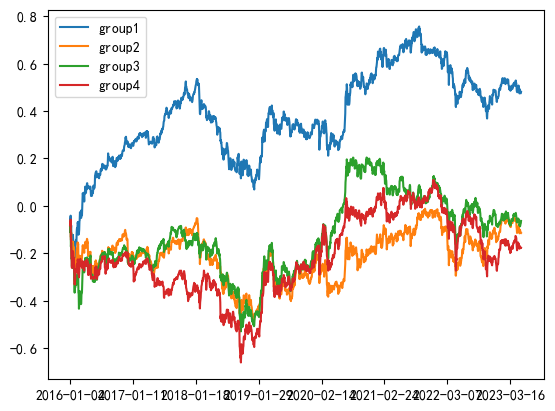

In [409]:
# 分组收益率
xy.cal_rate_group(
    New_ovn_TSR,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

#### 多头

shrh: 0.0 win%: 0.5179934569247546 gainloss%: -1.0500771309914925
shrh: 0.2 win%: 0.5184331797235023 gainloss%: -1.0457987586226194
shrh: 0.4 win%: 0.5264452644526445 gainloss%: -1.0940243752413124
shrh: 0.6 win%: 0.5328947368421053 gainloss%: -1.0777997288470291
shrh: 0.8 win%: 0.524024024024024 gainloss%: -1.0639112829064319


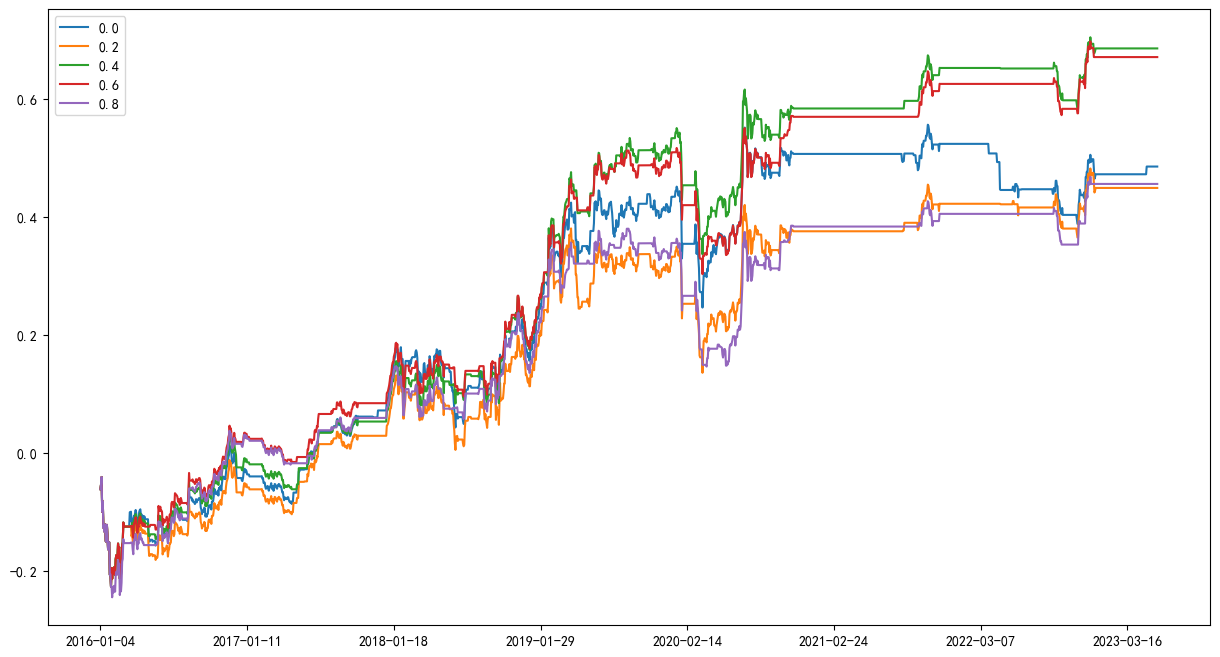

In [241]:
idx_name = '50'
for i in range(15)[::2]:
    i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(New_TSR1_idx.T[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[New_TSR1_idx.T[idx_name][New_TSR1_idx.T[idx_name]>i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
        
    # if i < 1.4:
    #     continue

    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(i),xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))
    
    if i == 0.8:
        break

In [238]:
ts_ret[ts_ret/ts_ret.shift()<0]

2016-01-05    0.007775
2016-01-07   -0.059137
2016-01-08    0.017896
2016-01-11   -0.044773
2016-01-12    0.005251
                ...   
2022-12-07   -0.005288
2022-12-08    0.000842
2022-12-12   -0.012118
2022-12-13    0.001107
2022-12-19   -0.015665
Name: 50, Length: 406, dtype: float64

#### 空头

shrh: 0.0 win%: 0.4976958525345622 gainloss%: -0.9456345567608521
shrh: 0.2 win%: 0.5036585365853659 gainloss%: -0.9324467286715544
shrh: 0.4 win%: 0.5065274151436031 gainloss%: -0.9112198314775933
shrh: 0.6 win%: 0.504297994269341 gainloss%: -0.9124547541108481


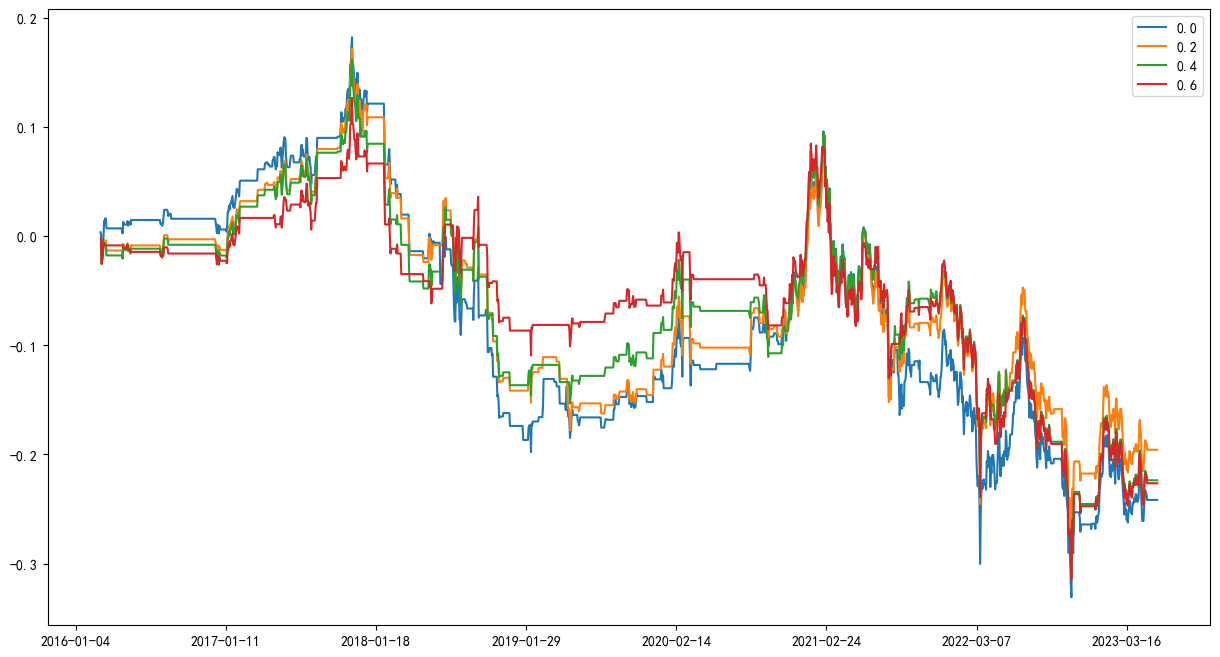

In [239]:
idx_name = '50'
for i in range(15)[::2]:
    i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(New_TSR1_idx.T[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[New_TSR1_idx.T[idx_name][New_TSR1_idx.T[idx_name]<-i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
    
    
        
    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    pd.Series(ts_ret.cumsum().rename(i), xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))
    
    if i == 0.6:
        break

In [240]:
ts_ret[ts_ret/ts_ret.shift()<0]

2016-03-11    0.004498
2016-03-17   -0.002175
2016-05-12    0.003092
2016-05-13   -0.004149
2016-08-02    0.000417
                ...   
2023-04-19   -0.008649
2023-04-25    0.000288
2023-04-26   -0.000479
2023-04-27    0.012449
2023-05-05   -0.002792
Name: 50, Length: 372, dtype: float64

## 评估

### cl-cl

-0.005304542389488867
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

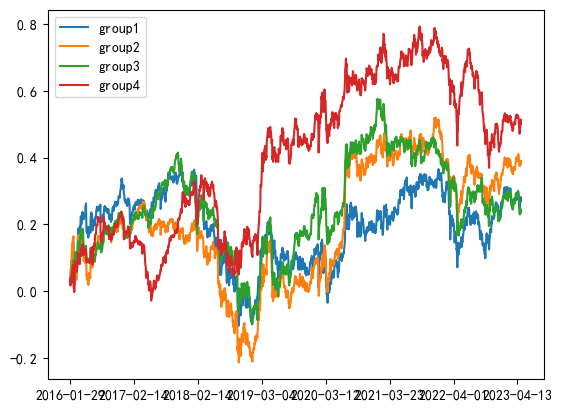

In [252]:
# 分组收益率
gr_ENPchange = xy.cal_rate_group(
    New_TSR,
    xy.Index_rets,
    group_num=4,
    masks=1
)
gr_ENPchange.cumsum().plot()

1200.0
yoy: 0.13930217658595143 
 mdd: -0.24263911959858697 
 sharpe: 0.8083180496890677 
 rankIC: 0.046514285714285716 
 rankIR: 0.060718360034692116 
 win%: 0.519327731092437 
 gain_loss%: -1.0222420349084191


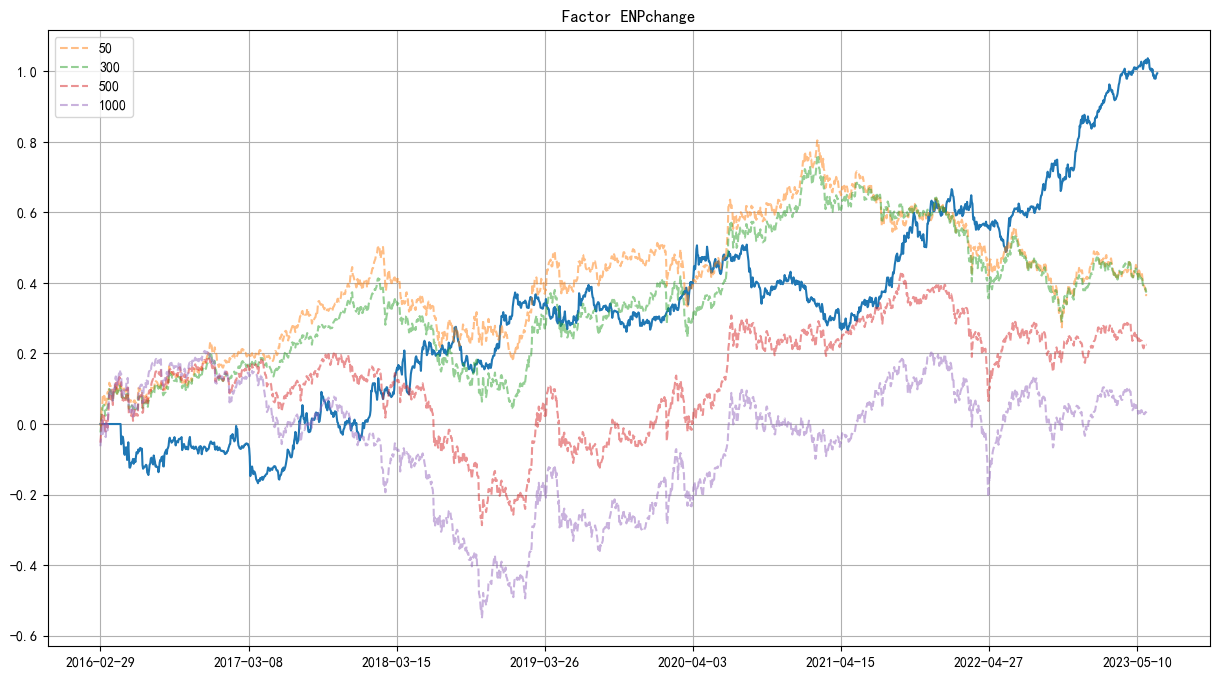

In [523]:
# 单因子强弱
ENPchange_select, ENPchange_rets = xy.single_Factor_backtest(
    New_TSR1_idx,
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='ENPchange'
)

0.046514285714285716

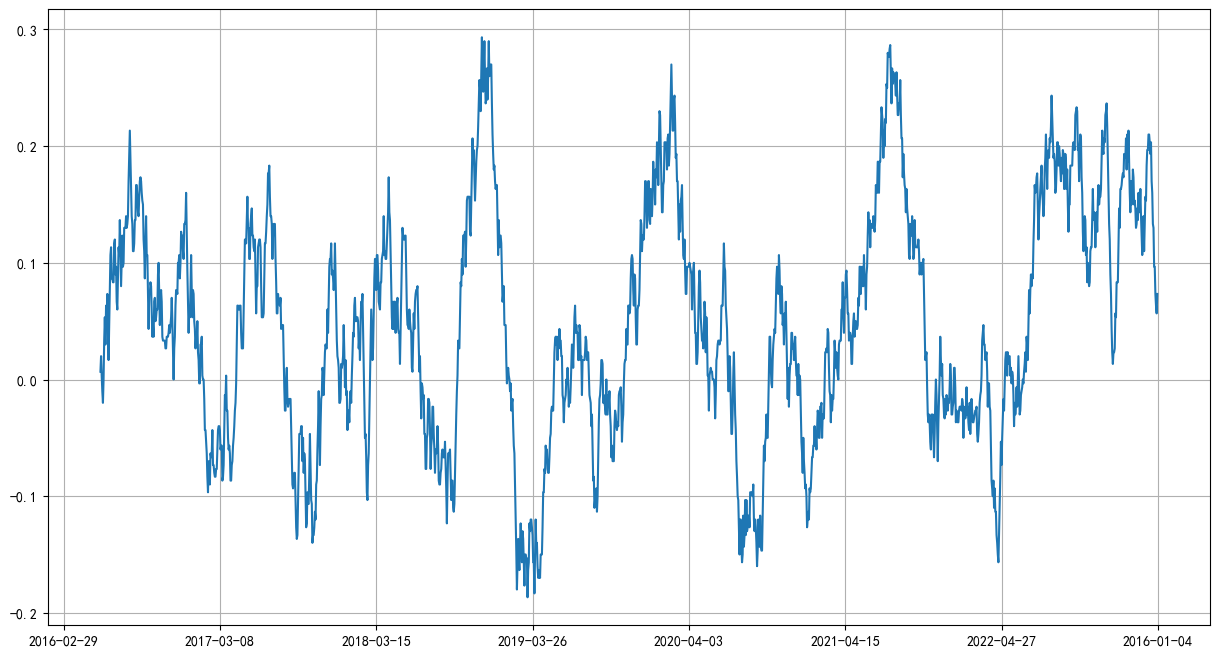

In [493]:
# 因子截面IC趋势
rankIC = xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### cl_op

-0.05012971921705416
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

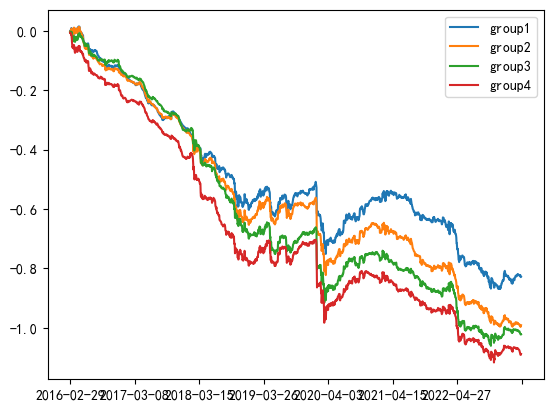

In [524]:
# 分组收益率
gr_ENPchange = xy.cal_rate_group(
    New_TSR1_idx.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_ENPchange.cumsum().plot()

1196.0
yoy: -0.037091003278173745 
 mdd: -0.31745989490437765 
 sharpe: -0.772221553049972 
 rankIC: -0.03474285714285715 
 rankIR: -0.0476398609918534 
 win%: 0.47314285714285714 
 gain_loss%: -0.9572870637371589


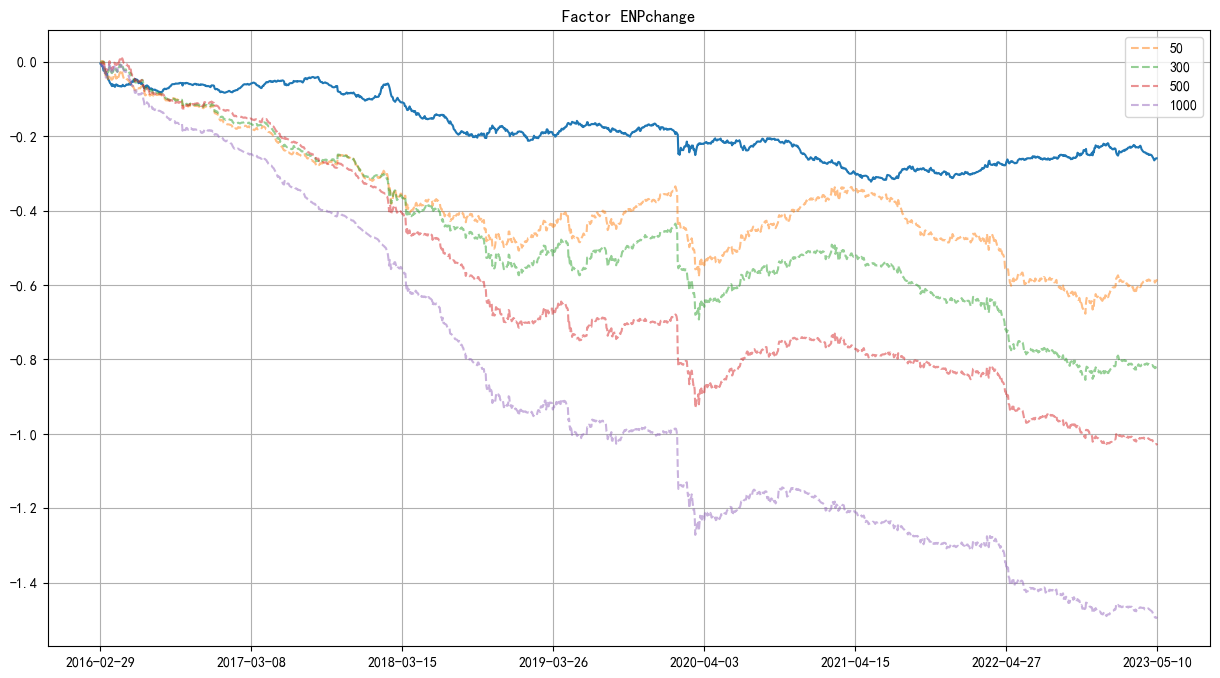

In [525]:
# 单因子强弱
ENPchange_select, ENPchange_rets = xy.single_Factor_backtest(
    New_TSR1_idx.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='ENPchange'
)

-0.03474285714285715

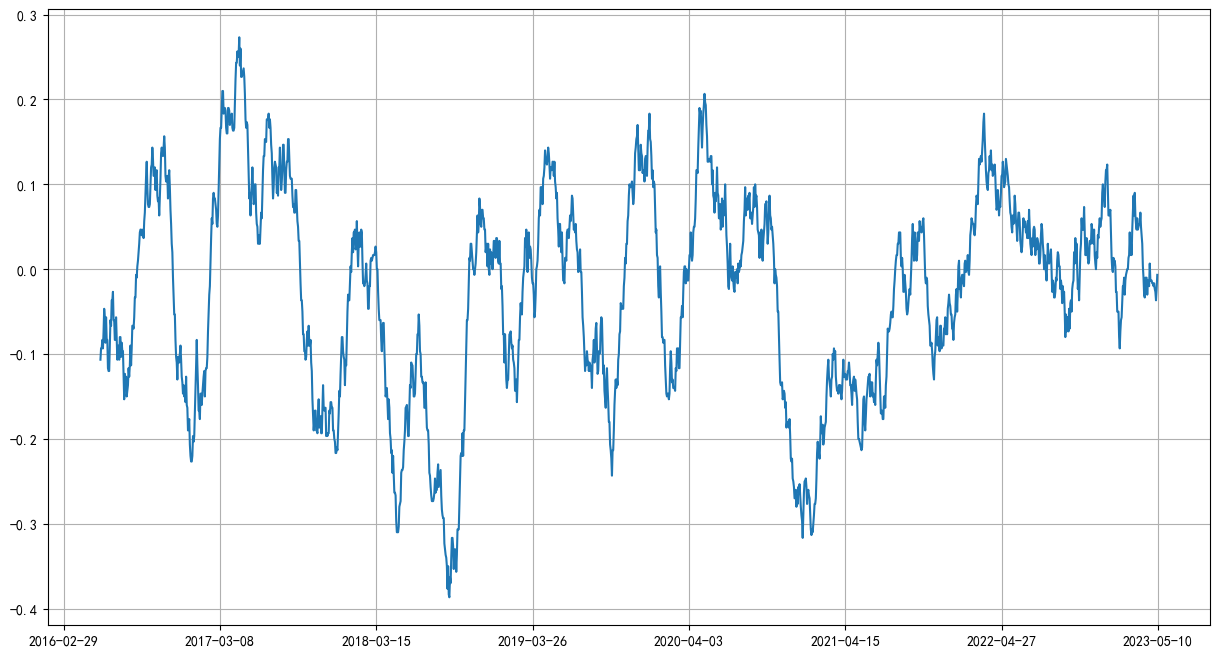

In [526]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### 择时

In [311]:
New_TSR

,2016-01-29,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-15,2016-02-16,2016-02-17,2016-02-18,...,2023-04-21,2023-04-24,2023-04-25,2023-04-26,2023-04-27,2023-04-28,2023-05-04,2023-05-05,2023-05-08,2023-05-09
50,0.147235,0.226462,1.930968,1.764611,1.508440,1.616129,1.754330,1.857371,1.925839,1.925839,...,-0.373158,0.157809,-0.898556,-0.218572,0.507251,1.803494,2.533228,2.403438,2.283654,2.237313
300,-0.350651,-0.180354,1.422594,1.234912,1.238376,1.420999,1.132818,0.808581,0.548959,0.548959,...,0.329314,-0.386280,-0.323111,0.273875,-1.049272,-1.349483,-1.132364,-2.331592,-2.250266,-2.602437
500,0.305772,-0.170631,-1.830181,-0.871996,-0.627495,-0.971579,-0.864574,-2.158523,-2.045980,-2.045980,...,0.521820,0.278926,1.243249,-0.667052,0.253414,-0.787568,-1.161915,-0.249733,-0.459283,0.304789
1000,-0.102355,0.124523,-1.523380,-2.127528,-2.119321,-2.065549,-2.022574,-0.507429,-0.428817,-0.428817,...,-0.477975,-0.050455,-0.021582,0.611749,0.288606,0.333557,-0.238948,0.177887,0.425895,0.060335


<Axes: >

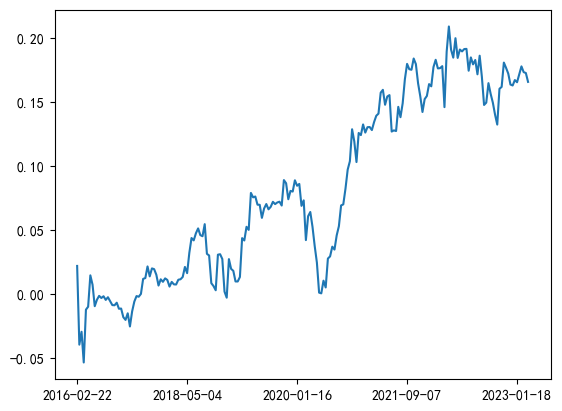

In [317]:
xy.Index_rets.T['300'].loc[New_TSR.T.dropna()['300'][New_TSR.T.dropna()['300']>1.5].index].cumsum().plot()

<Axes: >

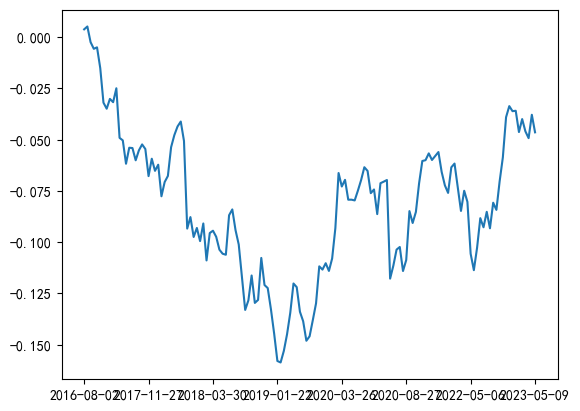

In [318]:
xy.Index_rets.T['300'].loc[New_TSR.T.dropna()['300'][New_TSR.T.dropna()['300']<-1.5].index].cumsum().plot()

In [86]:
New_TSR_idx

,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-18,2016-01-19,...,2023-08-14,2023-08-15,2023-08-16,2023-08-17,2023-08-18,2023-08-21,2023-08-22,2023-08-23,2023-08-24,2023-08-25
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.036845,-0.120872,-1.270599,-1.191130,-0.897793,-0.205790,0.333828,-0.506408,-0.569720,-0.995978
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.674886,1.442554,1.140688,1.167009,1.422207,1.376731,1.042910,1.347327,-0.951119,-0.649935
500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.808590,-0.785352,0.259854,0.342975,-0.132225,-0.151471,-0.035225,0.115585,1.314638,1.162880
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.903141,-0.536330,-0.129942,-0.318853,-0.392189,-1.019470,-1.341513,-0.956505,0.206201,0.483033


In [65]:
New_TSR1_idx.to_csv(r'E:\PyProject\factors\NewFactor\st_New_TSR_prepost_idx1.csv')

In [64]:
pd.read_csv(r'E:\PyProject\factors\NewFactor\st_New_TSR_idx.csv',index_col=0).loc[[50,1000],:]

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-05-24,2023-05-25,2023-05-26,2023-05-29,2023-05-30,2023-05-31,2023-06-01,2023-06-02,2023-06-05,2023-06-06
50,0.962962,0.905180,1.155897,0.606296,0.764528,1.313461,1.311309,1.361990,1.242439,1.209194,...,1.061463,1.293808,1.241196,1.215117,0.924308,-0.027575,-0.338067,-0.766041,-0.967313,-0.910719
1000,-1.401057,-1.421469,-1.212894,-1.482881,-1.468804,-1.049187,-1.083691,-0.991289,-1.074822,-1.186196,...,0.206869,-0.198436,0.212217,0.369666,0.573506,1.407143,1.426419,1.177426,1.261440,1.298776


806.0


ValueError: attempt to get argmax of an empty sequence

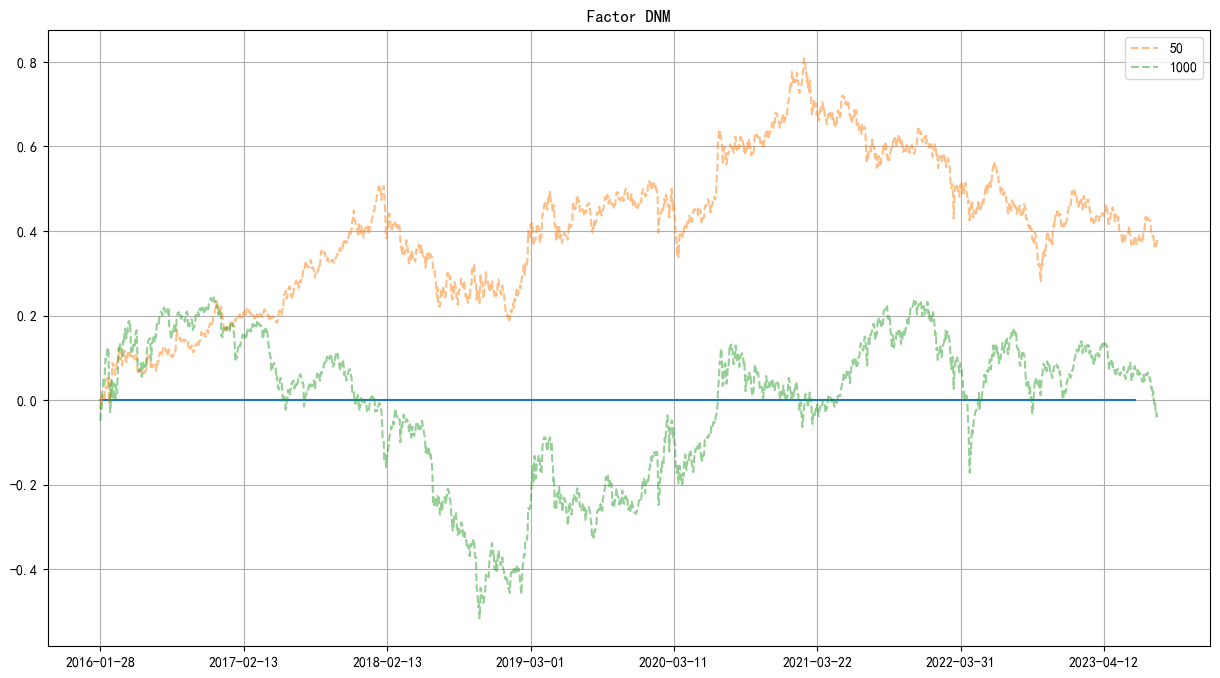

In [124]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    pd.read_csv(r'E:\PyProject\factors\NewFactor\st_New_TSR_idx.csv',index_col=0).loc[[50,1000],:],# ['50','1000']
    xy.Index_rets.loc[['50','1000'],'2016-01-28':],
    _side=1,
    fee=0.00,
    name='DNM'
)

In [63]:
pd.read_csv(r'E:\PyProject\factors\NewFactor\st_New_TSR_idx.csv',index_col=0)

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-05-24,2023-05-25,2023-05-26,2023-05-29,2023-05-30,2023-05-31,2023-06-01,2023-06-02,2023-06-05,2023-06-06
50,0.962962,0.905180,1.155897,0.606296,0.764528,1.313461,1.311309,1.361990,1.242439,1.209194,...,1.061463,1.293808,1.241196,1.215117,0.924308,-0.027575,-0.338067,-0.766041,-0.967313,-0.910719
300,0.302050,0.373900,0.337662,0.595247,0.281042,0.131593,0.086411,0.031007,0.295041,0.243965,...,-1.350465,-1.133674,-1.149904,-1.048389,-1.338408,-0.873608,-0.903887,-0.892070,-0.610647,-0.645957
500,0.136045,0.142389,-0.280665,0.281338,0.423233,-0.395867,-0.314030,-0.401708,-0.462659,-0.266963,...,0.082132,0.038302,-0.303509,-0.536393,-0.159406,-0.505961,-0.184464,0.480685,0.316520,0.257900
1000,-1.401057,-1.421469,-1.212894,-1.482881,-1.468804,-1.049187,-1.083691,-0.991289,-1.074822,-1.186196,...,0.206869,-0.198436,0.212217,0.369666,0.573506,1.407143,1.426419,1.177426,1.261440,1.298776
